In [47]:
import numpy as np
import pandas as pd
from pathlib import Path
import statsmodels.api as sm

data_path = Path("data")

# Read the 'Monthly' sheet from the median_house_price file
prices = pd.read_excel(data_path / "median_house_price.xlsx", sheet_name="Monthly")
# Ensure the date column is datetime
if not pd.api.types.is_datetime64_any_dtype(prices["observation_date"]):
    prices["observation_date"] = pd.to_datetime(prices["observation_date"])

# FIX: Actually set the index properly
prices = prices.set_index("observation_date")

# Read CPI file and parse dates; adjust column name if different
cpi_data = pd.read_excel(
    data_path / "cpi.xlsx",
    sheet_name="Monthly",
    parse_dates=["observation_date"]
)

# Ensure the date column is datetime
if not pd.api.types.is_datetime64_any_dtype(cpi_data["observation_date"]):
    cpi_data["observation_date"] = pd.to_datetime(cpi_data["observation_date"])

# Filter CPI data to start from 1963-01-01 (inclusive)
cpi_data = cpi_data[cpi_data["observation_date"] >= "1963-01-01"]

# Extract CPI series and set index
cpi = cpi_data.set_index("observation_date")["cpi"]

# Quick check
print(cpi.head())
print(f"Rows after filtering: {len(cpi)}")

# Calculate real house prices
cpi_100 = cpi / 100  # Convert CPI to index form
real_prices = prices.price / cpi_100  # Now both are properly indexed

# Read other datasets similarly and compute their monthly differences
loans = pd.read_excel(data_path / "loans.xlsx", sheet_name="Monthly")
loans = loans.set_index("observation_date")
log_loans = np.log(loans.loans)
log_loans = log_loans.to_frame(name='loans').set_index(loans.index)



net_wealth = pd.read_excel(data_path / "net_wealth_of_top_1.xlsx", sheet_name="Quarterly")
net_wealth = net_wealth.set_index("observation_date")
net_wealth.rename(columns={"percentage": "net_wealth"}, inplace=True)
net_wealth_monthly = net_wealth.resample('MS').interpolate(method='linear').ffill().bfill()

vacancy_rate = pd.read_excel(data_path / "vacancy_rate.xlsx", sheet_name="Quarterly")
vacancy_rate = vacancy_rate.set_index("observation_date")
vacancy_rate_monthly = vacancy_rate.resample('MS').interpolate(method='linear').ffill().bfill()

mortgage_rate = pd.read_excel(data_path / "MORTGAGE30US.xlsx", sheet_name="Weekly, Ending Thursday")
mortgage_rate = mortgage_rate.set_index("observation_date")
mortgage_rate.rename(columns={"MORTGAGE30US": "mortgage_rate"}, inplace=True)
mortgage_rate_monthly = mortgage_rate.resample('MS').interpolate(method='linear').ffill().bfill()

## Import more data
pca_path = Path("data/PCA")

active_listings = pd.read_excel(pca_path / "ACTLISCOUUS.xlsx", sheet_name="Monthly")
active_listings.rename(columns={"ACTLISCOUUS": "active_listings"}, inplace=True)
active_listings.set_index("observation_date", inplace=True)

median_house_income = pd.read_excel(pca_path / "MEHOINUSA672N.xlsx", sheet_name="Annual")
median_house_income['observation_date'] = pd.to_datetime(median_house_income['observation_date'], errors='coerce')
median_house_income.set_index('observation_date', inplace=True)
median_house_income.rename(columns={"MEHOINUSA672N": "median_house_income"}, inplace=True)
median_house_income_monthly = median_house_income.resample('MS').interpolate(method='linear').ffill().bfill()

monthly_supply_homes = pd.read_excel(pca_path / "MSACSR.xlsx", sheet_name="Monthly")
monthly_supply_homes.set_index("observation_date", inplace=True)
monthly_supply_homes.rename(columns={"MSACSR": "monthly_supply_homes"}, inplace=True)

labor_share = pd.read_excel(pca_path / "PRS85006173.xlsx", sheet_name="Quarterly")
labor_share.set_index("observation_date", inplace=True)
labor_share.rename(columns={"PRS85006173": "labor_share"}, inplace=True)
labor_share_monthly = labor_share.resample('MS').interpolate(method='linear').ffill().bfill()

unemployment_rate = pd.read_excel(pca_path / "UNRATE.xlsx", sheet_name="Monthly")
unemployment_rate.set_index("observation_date", inplace=True)
unemployment_rate.rename(columns={"UNRATE": "unemployment_rate"}, inplace=True)

share_net_worth_bottom_50 = pd.read_excel(pca_path / "WFRBSB50215.xlsx", sheet_name="Quarterly")
share_net_worth_bottom_50.set_index("observation_date", inplace=True)
share_net_worth_bottom_50.rename(columns={"WFRBSB50215": "share_net_worth_bottom_50"}, inplace=True)
share_net_worth_bottom_50_monthly = share_net_worth_bottom_50.resample('MS').interpolate(method='linear').ffill().bfill()
log_share_net_worth_bottom_50_monthly = np.log(share_net_worth_bottom_50_monthly.share_net_worth_bottom_50)
log_share_net_worth_bottom_50_monthly = log_share_net_worth_bottom_50_monthly.to_frame(name='share_net_worth_bottom_50').set_index(share_net_worth_bottom_50_monthly.index)

# Calculate monthly differences
log_real_prices = np.log(real_prices)
log_real_prices_diff = log_real_prices.diff().dropna()

log_loans_monthly_diff = log_loans.loans.diff().dropna()

time = np.arange(len(log_loans_monthly_diff))  # assuming loans is a time series


net_wealth_monthly_diff = net_wealth_monthly.net_wealth.diff().dropna()
vacancy_rate_monthly_diff = vacancy_rate_monthly.vacancy_rate.diff().dropna()
mortgage_rate_monthly_diff = mortgage_rate_monthly.mortgage_rate.diff().dropna()
active_listings_monthly_diff = active_listings.active_listings.diff().dropna()
median_house_income_monthly_diff = median_house_income_monthly.median_house_income.diff().dropna()
monthly_supply_homes_monthly_diff = monthly_supply_homes.monthly_supply_homes.diff().dropna()
labor_share_monthly_diff = labor_share_monthly.labor_share.diff().dropna()
unemployment_rate_monthly_diff = unemployment_rate.unemployment_rate.diff().dropna()
log_share_net_worth_bottom_50_monthly_diff = log_share_net_worth_bottom_50_monthly.share_net_worth_bottom_50.diff().dropna()
time = np.arange(len(log_share_net_worth_bottom_50_monthly_diff))  # assuming loans is a time series
X = sm.add_constant(time)  # Add constant to model for intercept

# Fit linear regression model
model = sm.OLS(log_share_net_worth_bottom_50_monthly_diff, X)
results = model.fit()

# Detrended data (subtract the fitted trend)
detrended_share_net_worth = log_share_net_worth_bottom_50_monthly_diff - results.fittedvalues
# FIX: Use the actual index from log_real_prices_diff
idx = log_real_prices_diff.index

# Combine all variables into a single DataFrame
data = pd.DataFrame({
    'real_prices_diff': log_real_prices_diff,
    'log_loans_diff': log_loans_monthly_diff.reindex(idx),
    'net_wealth_diff': net_wealth_monthly_diff.reindex(idx),
    'vacancy_rate_diff': vacancy_rate_monthly_diff.reindex(idx),
    'mortgage_rate_diff': mortgage_rate_monthly_diff.reindex(idx),
    # 'active_listings_diff': active_listings_monthly_diff.reindex(idx),
    'median_house_income_diff': median_house_income_monthly_diff.reindex(idx),
    'monthly_supply_homes_diff': monthly_supply_homes_monthly_diff.reindex(idx),
    'labor_share_diff': labor_share_monthly_diff.reindex(idx),
    'unemployment_rate_diff': unemployment_rate_monthly_diff.reindex(idx),
    'log_share_net_worth': log_share_net_worth_bottom_50_monthly_diff.reindex(idx)
}, index=idx)

data = data.dropna()
# Check for missing values
print("\nMissing values per column:")
print(data.isnull().sum())
print(f"\nData shape: {data.shape}")
print(f"\nDate range: {data.index.min()} to {data.index.max()}")
# remove rows with any missing values

print(f"\nData shape after dropping missing values: {data.shape}")

observation_date
1963-01-01    30.44
1963-02-01    30.48
1963-03-01    30.51
1963-04-01    30.48
1963-05-01    30.51
Name: cpi, dtype: float64
Rows after filtering: 752

Missing values per column:
real_prices_diff             0
log_loans_diff               0
net_wealth_diff              0
vacancy_rate_diff            0
mortgage_rate_diff           0
median_house_income_diff     0
monthly_supply_homes_diff    0
labor_share_diff             0
unemployment_rate_diff       0
log_share_net_worth          0
dtype: int64

Data shape: (414, 10)

Date range: 1989-08-01 00:00:00 to 2024-01-01 00:00:00

Data shape after dropping missing values: (414, 10)


In [48]:
from statsmodels.tsa.api import VAR
import numpy as np


# Fit VAR model and test different lag orders
model = VAR(data)
lag_order_results = model.select_order(maxlags=12)
print(lag_order_results.summary())

# # This will show AIC, BIC, HQIC for different lags
# # Lower values = better
# optimal_lag = lag_order_results.aic  # or .bic, .hqic

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -33.37      -33.27   3.230e-15      -33.33
1       -39.97     -38.88*   4.374e-18      -39.54
2       -40.06      -37.97   4.010e-18      -39.23
3       -40.60      -37.52   2.331e-18      -39.38
4      -41.26*      -37.19  1.209e-18*     -39.65*
5       -41.09      -36.02   1.442e-18      -39.09
6       -40.96      -34.90   1.658e-18      -38.56
7       -41.21      -34.15   1.318e-18      -38.41
8       -40.92      -32.87   1.783e-18      -37.74
9       -40.88      -31.84   1.904e-18      -37.30
10      -41.19      -31.15   1.439e-18      -37.22
11      -41.04      -30.00   1.745e-18      -36.67
12      -40.92      -28.90   2.043e-18      -36.16
--------------------------------------------------


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [49]:
from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Check cross-correlations between each predictor and target
predictors = [col for col in data.columns if col != 'real_prices_diff']

# test stationarity for each predictor
for predictor in predictors:
    clean_data = data[['real_prices_diff', predictor]].dropna()
    adf_result = adfuller(clean_data[predictor])
    print(f"ADF Statistic for {predictor}: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    for key, value in adf_result[4].items():
        print('Critical Value (%s): %.3f' % (key, value))
    print("\n")


ADF Statistic for log_loans_diff: -2.842514453121344
p-value: 0.052452805690833305
Critical Value (1%): -3.446
Critical Value (5%): -2.869
Critical Value (10%): -2.571


ADF Statistic for net_wealth_diff: -4.057258937274642
p-value: 0.0011386487006139368
Critical Value (1%): -3.447
Critical Value (5%): -2.869
Critical Value (10%): -2.571


ADF Statistic for vacancy_rate_diff: -3.2990743390492203
p-value: 0.01491990230052271
Critical Value (1%): -3.447
Critical Value (5%): -2.869
Critical Value (10%): -2.571


ADF Statistic for mortgage_rate_diff: -4.669560439915263
p-value: 9.595944004315498e-05
Critical Value (1%): -3.447
Critical Value (5%): -2.869
Critical Value (10%): -2.571


ADF Statistic for median_house_income_diff: -2.9010634352920195
p-value: 0.04522447409780557
Critical Value (1%): -3.447
Critical Value (5%): -2.869
Critical Value (10%): -2.571


ADF Statistic for monthly_supply_homes_diff: -10.655983870404778
p-value: 4.533204606814764e-19
Critical Value (1%): -3.446
Critic

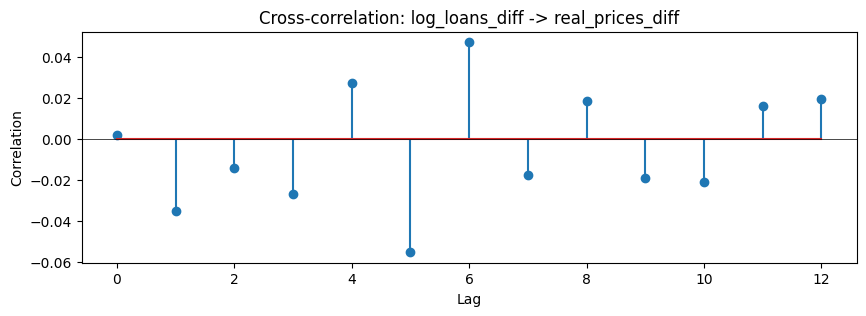

log_loans_diff: Significant lags at []



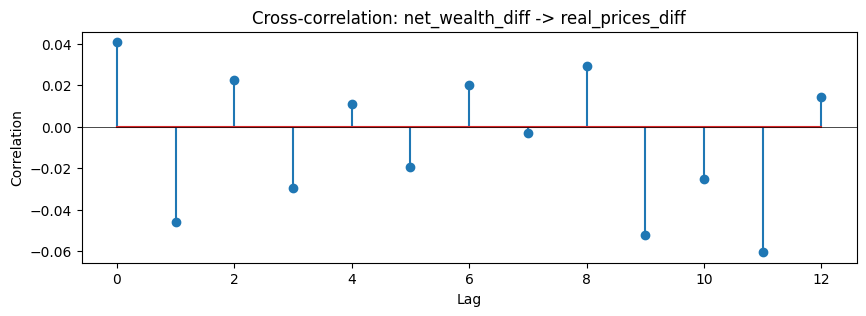

net_wealth_diff: Significant lags at []



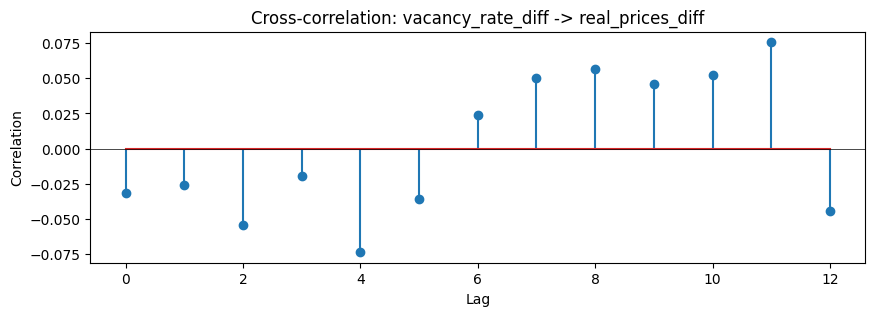

vacancy_rate_diff: Significant lags at []



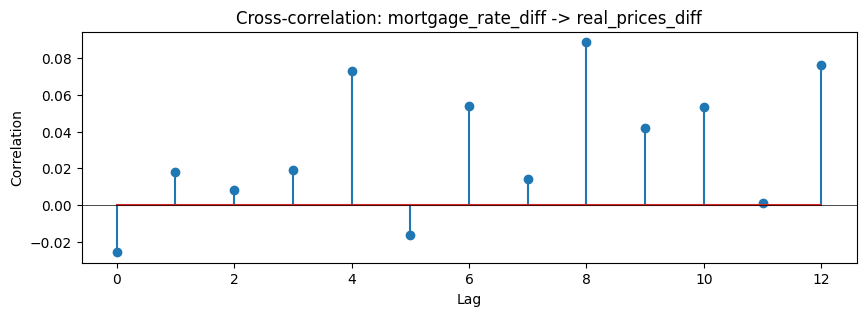

mortgage_rate_diff: Significant lags at []



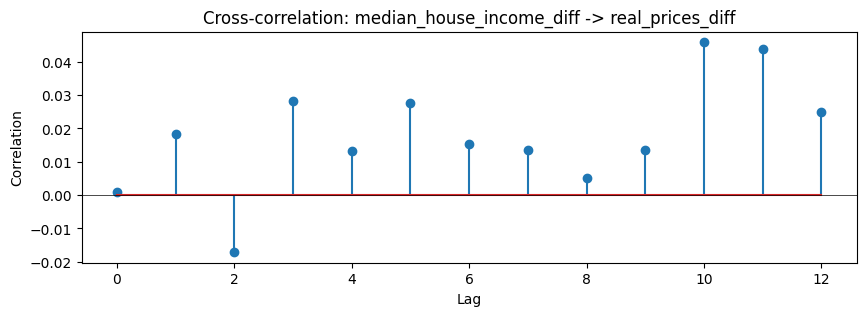

median_house_income_diff: Significant lags at []



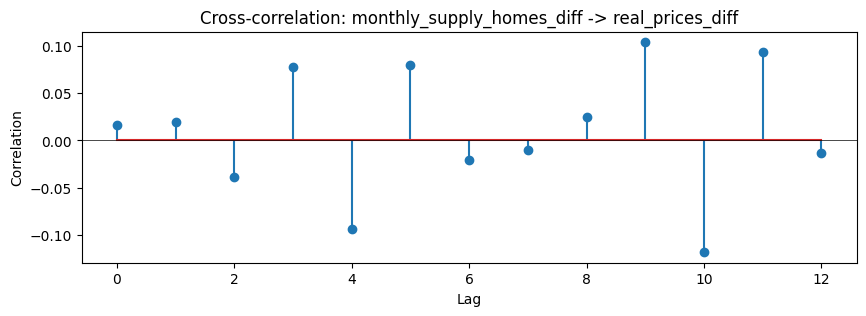

monthly_supply_homes_diff: Significant lags at [9, 10]



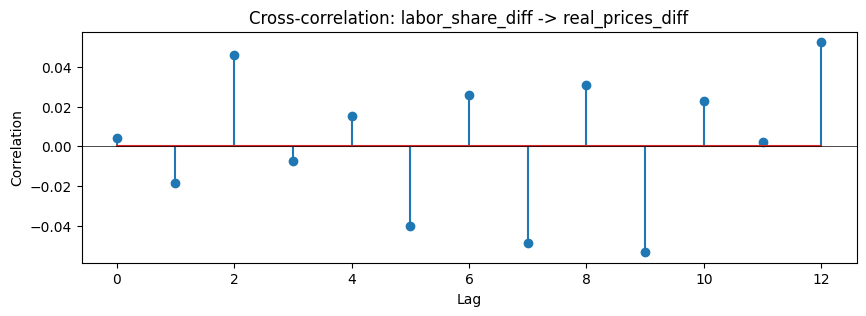

labor_share_diff: Significant lags at []



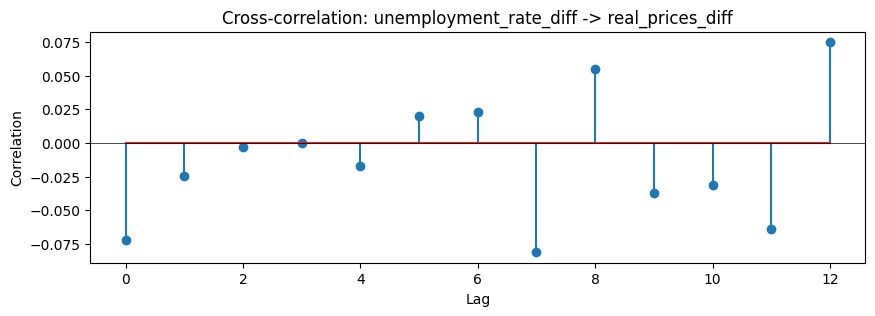

unemployment_rate_diff: Significant lags at []



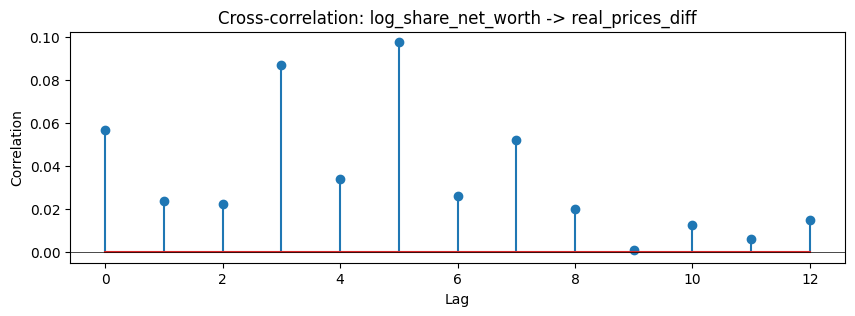

log_share_net_worth: Significant lags at []



In [50]:


for predictor in predictors:
    clean_data = data[['real_prices_diff', predictor]].dropna()
    correlations = ccf(clean_data[predictor], clean_data['real_prices_diff'])[:13]
    
    plt.figure(figsize=(10, 3))
    plt.stem(range(len(correlations)), correlations)
    plt.title(f'Cross-correlation: {predictor} -> real_prices_diff')
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    plt.show()
    
    # Print significant lags (rule of thumb: |corr| > 2/sqrt(n))
    threshold = 2/np.sqrt(len(clean_data))
    significant_lags = [i for i, corr in enumerate(correlations) if abs(corr) > threshold]
    print(f"{predictor}: Significant lags at {significant_lags}\n")

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf, grangercausalitytests
from scipy import stats
import seaborn as sns

# Assuming your data DataFrame is already defined
# data = pd.DataFrame({...})

def find_significant_lags(data, target_col='real_prices_diff', max_lag=12):
    """
    Find significant lags using practical methods that work well with differenced data
    Focus on: Cross-correlation, Individual regressions, and PACF
    """
    predictors = [col for col in data.columns if col != target_col]
    results = {}
    
    print("="*80)
    print("FINDING SIGNIFICANT LAGS FOR PREDICTORS")
    print("="*80)
    
    message = ""
    
    for predictor in predictors:
        print(f"\n{'='*80}")
        print(f"Analyzing: {predictor}")
        print(f"{'='*80}")
        
        # Clean data
        clean_data = data[[target_col, predictor]].dropna()
        n = len(clean_data)
        
        if n < max_lag + 10:
            print(f"⚠️  Insufficient data (n={n}). Skipping.")
            continue
        
        # Method 1: Cross-Correlation Function (Most reliable for differenced data)
        print("\n--- Cross-Correlation Analysis ---")
        ccf_values = ccf(clean_data[predictor], clean_data[target_col], adjusted=False)[:max_lag+1]
        
        # Significance threshold: ±1.96/sqrt(n) for 95% confidence
        threshold = 1.96 / np.sqrt(n)
        
        significant_lags_ccf = []
        for lag in range(max_lag + 1):
            if abs(ccf_values[lag]) > threshold:
                significant_lags_ccf.append(lag)
                sig_marker = '***' if abs(ccf_values[lag]) > 2*threshold else '**'
                print(f"  Lag {lag}: {ccf_values[lag]:.4f} {sig_marker}")
        
        if not significant_lags_ccf:
            print("  No significant lags found")
        
        # Method 2: Individual Lag Regressions (More powerful than Granger for single predictors)
        print("\n--- Individual Lag Regression t-tests ---")
        from statsmodels.api import OLS, add_constant
        
        significant_lags_regression = []
        regression_results = {}
        
        for lag in range(1, max_lag + 1):
            # Create lagged predictor
            lagged_data = pd.DataFrame({
                'y': clean_data[target_col].values[lag:],
                'x_lag': clean_data[predictor].values[:-lag]
            })
            
            X = add_constant(lagged_data['x_lag'])
            y = lagged_data['y']
            
            model = OLS(y, X).fit()
            p_value = model.pvalues['x_lag']
            coef = model.params['x_lag']
            t_stat = model.tvalues['x_lag']
            regression_results[lag] = {'coef': coef, 'p_value': p_value, 't_stat': t_stat}
            
            if p_value < 0.1:  # Using 10% threshold for screening
                significant_lags_regression.append(lag)
                sig_marker = '***' if p_value < 0.01 else '**' if p_value < 0.05 else '*'
                print(f"  Lag {lag}: coef = {coef:.6f}, t-stat = {t_stat:.3f}, p = {p_value:.4f} {sig_marker}")
                message += f"Predictor {predictor} has significant lag {lag} (p={p_value:.4f})\n"
        
        if not significant_lags_regression:
            print("  No significant lags found (p < 0.1)")
        
        # Method 3: Stepwise regression (test multiple lags together)
        print("\n--- Stepwise Regression (controlling for other lags) ---")
        from statsmodels.api import OLS, add_constant
        
        # Test all lags together
        lag_data = pd.DataFrame({'y': clean_data[target_col].values[max_lag:]})
        
        for lag in range(1, max_lag + 1):
            lag_data[f'x_lag{lag}'] = clean_data[predictor].values[max_lag-lag:-lag]
        
        X_full = add_constant(lag_data.drop('y', axis=1))
        y_full = lag_data['y']
        
        model_full = OLS(y_full, X_full).fit()
        
        print(f"\n  Full model R² = {model_full.rsquared:.4f}, Adj. R² = {model_full.rsquared_adj:.4f}")
        print("  Significant lags in joint model:")
        
        joint_significant = []
        for lag in range(1, max_lag + 1):
            col_name = f'x_lag{lag}'
            if col_name in model_full.pvalues.index:
                p_val = model_full.pvalues[col_name]
                if p_val < 0.1:
                    joint_significant.append(lag)
                    coef = model_full.params[col_name]
                    sig_marker = '***' if p_val < 0.01 else '**' if p_val < 0.05 else '*'
                    print(f"    Lag {lag}: coef = {coef:.6f}, p = {p_val:.4f} {sig_marker}")
                    message += f"Predictor {predictor} has significant lag {lag} (p={p_val:.4f})\n"
        
        if not joint_significant:
            print("    No significant lags in joint model")
        
        # Store results
        results[predictor] = {
            'ccf_values': ccf_values,
            'ccf_threshold': threshold,
            'significant_lags_ccf': significant_lags_ccf,
            'significant_lags_regression': significant_lags_regression,
            'regression_results': regression_results,
            'joint_significant': joint_significant,
            'full_model_r2': model_full.rsquared_adj,
            'n_obs': n
        }
        
        # Summary recommendation
        print("\n--- RECOMMENDATION ---")
        # Combine evidence from different methods
        all_significant = set(significant_lags_ccf) | set(significant_lags_regression) | set(joint_significant)
        
        if all_significant:
            recommended_lags = sorted(list(all_significant))
            print(f"  ✓ Recommended lags to include: {recommended_lags} for predictor {predictor}")
            message += f"Predictor {predictor} has significant lags: {recommended_lags}\n"
            
            # Categorize by strength of evidence
            strong_lags = set(significant_lags_ccf) & set(significant_lags_regression)
            if strong_lags:
                print(f"  ✓✓ Strongest evidence for lags: {sorted(list(strong_lags))}")
                message += f"Strong evidence for lags: {sorted(list(strong_lags))}\n"
        else:
            print(f"  ✗ No significant lags found. Consider excluding this predictor or using contemporaneous value only for {predictor}")
            message += f"Predictor {predictor} has no significant lags. Consider excluding or using contemporaneous value only.\n"
    print(message)
    return results


def plot_lag_analysis(results, data, target_col='real_prices_diff'):
    """
    Create visualizations of lag relationships
    """
    predictors = list(results.keys())
    n_predictors = len(predictors)
    
    fig, axes = plt.subplots(n_predictors, 2, figsize=(14, 4*n_predictors))
    if n_predictors == 1:
        axes = axes.reshape(1, -1)
    
    for idx, predictor in enumerate(predictors):
        res = results[predictor]
        max_lag = len(res['ccf_values']) - 1
        lags = range(max_lag + 1)
        
        # Plot 1: Cross-correlation
        ax1 = axes[idx, 0]
        ax1.stem(lags, res['ccf_values'], basefmt=' ')
        ax1.axhline(y=res['ccf_threshold'], color='r', linestyle='--', label='95% CI')
        ax1.axhline(y=-res['ccf_threshold'], color='r', linestyle='--')
        ax1.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
        ax1.set_xlabel('Lag')
        ax1.set_ylabel('Cross-correlation')
        ax1.set_title(f'{predictor}\nCross-correlation with {target_col}')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Highlight significant lags
        for lag in res['significant_lags_ccf']:
            ax1.axvspan(lag-0.3, lag+0.3, alpha=0.2, color='green')
        
        # Plot 2: Regression coefficients and p-values
        ax2 = axes[idx, 1]
        reg_results = res['regression_results']
        lags_reg = list(reg_results.keys())
        coefs = [reg_results[lag]['coef'] for lag in lags_reg]
        p_values = [reg_results[lag]['p_value'] for lag in lags_reg]
        
        # Bar plot of coefficients with color based on significance
        colors = ['green' if p < 0.05 else 'orange' if p < 0.1 else 'gray' 
                  for p in p_values]
        ax2.bar(lags_reg, coefs, color=colors, alpha=0.6)
        ax2.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
        ax2.set_xlabel('Lag')
        ax2.set_ylabel('Regression Coefficient')
        ax2.set_title(f'{predictor}\nIndividual Lag Coefficients\n(Green: p<0.05, Orange: p<0.1)')
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    # plt.show()


def create_optimal_lag_model(data, results, target_col='real_prices_diff', 
                             min_lag_evidence=1):
    """
    Create a regression model using the identified significant lags
    
    Parameters:
    -----------
    min_lag_evidence : int
        Minimum number of methods that must agree on lag significance (1-3)
    """
    from statsmodels.api import OLS, add_constant
    
    print("\n" + "="*80)
    print("BUILDING OPTIMAL LAG MODEL")
    print("="*80)
    
    # Collect all recommended lags
    model_features = {}
    
    for predictor, res in results.items():
        # Count evidence for each lag
        all_lags = set(res['significant_lags_ccf']) | \
                   set(res['significant_lags_regression']) | \
                   set(res.get('joint_significant', []))
        
        if all_lags:
            # For each lag, count how many methods found it significant
            lag_evidence = {}
            for lag in all_lags:
                evidence = 0
                if lag in res['significant_lags_ccf']:
                    evidence += 1
                if lag in res['significant_lags_regression']:
                    evidence += 1
                if lag in res.get('joint_significant', []):
                    evidence += 1
                lag_evidence[lag] = evidence
            
            # Keep lags with sufficient evidence
            selected_lags = [lag for lag, ev in lag_evidence.items() 
                           if ev >= min_lag_evidence]
            
            if selected_lags:
                model_features[predictor] = sorted(selected_lags)
                print(f"\n{predictor}:")
                print(f"  Selected lags: {selected_lags}")
    
    # Build the model
    print("\n" + "-"*80)
    print("Building regression model...")
    
    # Determine maximum lag needed
    max_lag_needed = max([max(lags) for lags in model_features.values()])
    
    # Create lagged features
    model_data = pd.DataFrame({target_col: data[target_col].values[max_lag_needed:]})
    
    for predictor, lags in model_features.items():
        for lag in lags:
            col_name = f'{predictor}_lag{lag}'
            model_data[col_name] = data[predictor].values[max_lag_needed-lag:-lag]
    
    # Remove NaN values
    model_data = model_data.dropna()
    # save model_data for inspection
    model_data.to_csv("optimal_lag_model_data.csv", index=False)
    
    print(f"\nModel data shape: {model_data.shape}")
    print(f"Number of features: {model_data.shape[1] - 1}")
    print(f"Number of observations: {model_data.shape[0]}")
    
    # Fit model
    y = model_data[target_col]
    X = add_constant(model_data.drop(target_col, axis=1))
    
    model = OLS(y, X).fit()
    
    print("\n" + "="*80)
    print("MODEL RESULTS")
    print("="*80)
    print(model.summary())
    
    return model, model_data, model_features


# Example usage:
results = find_significant_lags(data, max_lag=12)
# plot_lag_analysis(results, data)
model, model_data, features = create_optimal_lag_model(data, results, min_lag_evidence=1)


FINDING SIGNIFICANT LAGS FOR PREDICTORS

Analyzing: log_loans_diff

--- Cross-Correlation Analysis ---
  No significant lags found

--- Individual Lag Regression t-tests ---
  No significant lags found (p < 0.1)

--- Stepwise Regression (controlling for other lags) ---

  Full model R² = 0.0224, Adj. R² = -0.0077
  Significant lags in joint model:
    No significant lags in joint model

--- RECOMMENDATION ---
  ✗ No significant lags found. Consider excluding this predictor or using contemporaneous value only for log_loans_diff

Analyzing: net_wealth_diff

--- Cross-Correlation Analysis ---
  No significant lags found

--- Individual Lag Regression t-tests ---
  Lag 2: coef = 0.029836, t-stat = 1.693, p = 0.0911 *

--- Stepwise Regression (controlling for other lags) ---

  Full model R² = 0.0175, Adj. R² = -0.0128
  Significant lags in joint model:
    Lag 9: coef = 0.083280, p = 0.0705 *

--- RECOMMENDATION ---
  ✓ Recommended lags to include: [2, 9] for predictor net_wealth_diff

Ana

In [ ]:
# create a optimal OLS model using the last OLS model

# load optimal_lag_model_data.csv
optimal_data = pd.read_csv("optimal_lag_model_data.csv")
optimal_data['y_lag_1'] = optimal_data['real_prices_diff'].shift(-1)
optimal_data['y_lag_2'] = optimal_data['real_prices_diff'].shift(-2)
optimal_data['y_lag_3'] = optimal_data['real_prices_diff'].shift(-3)
optimal_data = optimal_data.dropna()

from sklearn.model_selection import train_test_split
from statsmodels.api import OLS, add_constant
      
# split into X and y
y_optimal = optimal_data['real_prices_diff']


X_optimal = optimal_data.drop(columns=['real_prices_diff'], axis=1)
# drop first 3 rows to align with y_optimal
y_train, y_test = train_test_split(y_optimal, test_size=0.2, shuffle=False)         
X_train, X_test = train_test_split(X_optimal, test_size=0.2, shuffle=False)

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Select the specified features
features = [
    'mortgage_rate_diff_lag9',
    'mortgage_rate_diff_lag10', 
    'median_house_income_diff_lag9',
    'median_house_income_diff_lag10',
    'median_house_income_diff_lag11',
    'y_lag_1', 'y_lag_2', 'y_lag_3'
]

X_train_selected = X_train[features]
X_test_selected = X_test[features]

# Fit OLS model
ols_model = LinearRegression()
ols_model.fit(X_train_selected, y_train)

# One-step ahead predictions on test set
y_pred = ols_model.predict(X_test_selected)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("OLS Model - One-Step Ahead Predictions")
print("=" * 50)
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")
print(f"\nCoefficients:")
for feature, coef in zip(features, ols_model.coef_):
    print(f"  {feature}: {coef:.6f}")
print(f"  Intercept: {ols_model.intercept_:.6f}")

# Show first few predictions vs actual
comparison = pd.DataFrame({
    'Actual': y_test[:10].values,
    'Predicted': y_pred[:10],
    'Error': y_test[:10].values - y_pred[:10]
})
print(f"\nFirst 10 Predictions:")
print(comparison)       

KeyError: "['y_lag_1', 'y_lag_2', 'y_lag_3'] not in index"